<a href="https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/notebooks/Tutorial_Basics_of_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenPack Challenge | Tutorial: Overview of OpenPack Dataset and Basics of Modeling

**NOTE: When you run this notebook on colab, please change runtime to GPU.**

NOTE: This notebook does not describe the procedure to make a submission file for OpenPack Challenge 2022. Plese refer to other tutorials.

In [1]:
import torch

if not torch.cuda.is_available():
    raise ValueError("Change notebook runtime to GPU !")

In [2]:
! nvidia-smi

Sun Feb  4 06:40:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## [1] Introduction

This notebook is prepared as a tutorial for [OpenPack Challenge　2022](https://open-pack.github.io/challenge2022) held in [Percom 2023 Workshop　BiRD](https://bio-navigation.jp/bird2023/).
In this notebook, we will describe two things, (1) overview of OpenPack dataset, (2) basic ideas to build a work activity recognition model.

### 1-1: Expected Learner

- Participants or prospective participants in the OpenPack Challenge
- Anyone who wants to get an overview of the OpenPack Dataset
- Anyone who wants to get a basic introduction to machine learning (Neural Network) modeling.

You do not need to have high-level machine learning knowledge to follow this tutorial, but knowledge of the basics of machine learning is recommended.

## [2] Overview of OpenPack Dataset

**OpenPacking Dataset** is a new large-scale multi-modal dataset in industrial domain.
Activities in the packaging work are recorded using 9 types of sensors such as IMUs and depth sensors.
Total recording length is more than 53 hours.

> **Characteristics of OpenPack Dataset**
> 1. A large industrial domain activity recognition dataset totaling over 53 hours of data
> 1. 9 sensor types, including data from IoT devices deployed in smart factories
> 1. Rich metadata such as worker's packing experience and the products to be packed

For more information, please visit [website](https://open-pack.github.io).

OpenPack Dataset is a dataset for activity recognition research, with labels assigned to the following 10 types of work operations.
In this notebook, we estimate which operation is being performed in each second for a given sensor data.
Sample videos (depth images) are uploaded on [Youtube](https://www.youtube.com/channel/UC-AzuKxoJcyOtFi7B3CS4rA). You can get an idea of the flow of the packing process by watching this video.

> **OpenPack: Activity Class**
> - 100: Picking
> - 200: Relocate Item Label
> - 300: Assemble Box
> - 400: Insert Items
> - 500: Close Box
> - 600: Attach Box Label
> - 700: Scan Label
> - 800: Attaching Shipping Label
> - 900: Put on Back Table
> - 1000: Fill out Order

The main task of the OpenPack Dataset is to "recognize the work operations in a packing work.
However, recognition is not an easy task.
For example, if you want to recognize a "walk," you only need to capture the periodic movements of the limbs, but in the case of a work operation, there are very few repetitive movements, and you also need to deal with the following issues.

1. The speed of operation varies greatly depending on the skill level of the subject.
1. The combination of items to be packed is different each time. The size of the box used depends on the size of the items. Furthermore, the number of times of inserting the products into the box will change if the number of items is different.
1. The work procedure is basically fixed, but for more efficient work, skilled workers may change some parts of the procedure, or the order may be changed due to mistakes.

![](https://github.com/open-pack/openpack-torch/blob/main/assets/img/OpenPack__KeyVisual.png?raw=1)

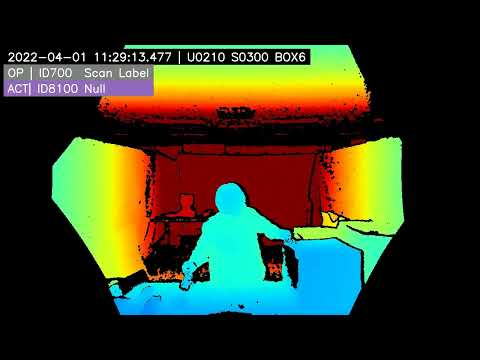

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('KRG5zv3ueRQ', width=600, height=400)

## [3] Sample Programs

From here on, we will build a neural network that estimates 10 different work operations every second, using acceleration data collected by IMU sensors attached to the left wrists as input.
We want to focus on learning the basic ideas of modeling, so there are several codes required, but if there are no specific instructions, just run the code as it is.
If you wish to try more advanced experiments, such as data preprocessing or modifying the training method, we hope you will deepen your understanding in another tutorial.

- Input: acceleration signal collected from the left wrist at 30 Hz for 60 seconds (Shape of input Tensor: `(1800, 6)`)
- Output: Work operation labels every 1 second (Shape of Tensor: `(60, 10)`)
- Model: Neural Network (PyTorch)

![](https://github.com/open-pack/openpack-torch/blob/main/assets/img/tutorial/task.jpg?raw=1)

### Model for Activity Recognition

In this section, we briefly summarize what perspectives should be taken to build an activity recognition model.
The implementation and parameters to consider are explained while running the sample below.

First, here are some examples of what to consider when dealing with multimodal time series data.

1. Temporal Dependencies
    1. range to be considered (1 sec? 10 seconds?) ... Set the range with reference to the duration of the activities to be recognized, etc.
    1. whether to consider only the forward temporal dependency or backword temporal dependency?　... When classifying "taps" and "double taps," it is necessary to consider both the past and the future in order to distinguish which is the first tap.
1. Modality
    1. sensor fusion (extract features for both hand movements at once? OR perform separate feature extraction for right and left wrist and then combine them?) ... Since the left and right hands can move independently, it may be more effective to consider them separately. 1.
    1. how to combine with other modalities (video, logs from IoT devices, etc.)

It is difficult to cover everything in this tutorial, so we will consider **temporal dependency**.

### Key Aspect to buld model for Operations in OpenPack Dataset

Basically the same as the above two items, but we will explain more specific part to OpenPack Dataset.

- The movements are mainly performed with the hands only. Therefore, there are many movements that are very similar in acceleration data alone.
    - e.g.) Arm movement: Assemble Box and Close Box
    - It is considered effective to estimate the activityt at the time of interest **using the previous and following work processes as a clue**.
- Activity order is basically fixed.
    - The order of activities is approximately fixed because the workflow is fixed.
    - The **actitity order can be a important hint** for prediction.
    - (Note) As the accuracy increases to a certain degree, misrecognition of out-of-normal order due to work errors becomes an issue.　In order to improve the accuracy, how to handle this part is important to improve accuracy.

![](https://github.com/open-pack/openpack-torch/blob/main/assets/img/tutorial/work_HAR_idea.jpg?raw=1)

------
Let's move to implementation part.

## [4] Inialize Environment (Please execute only once)

### 4-1: Download Code and Install `openpack-torch`

In [3]:
# download sample codes
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

Cloning into 'openpack-torch'...
remote: Enumerating objects: 1249, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1249 (delta 125), reused 342 (delta 99), pack-reused 831
Receiving objects: 100% (1249/1249), 55.48 MiB | 22.60 MiB/s, done.
Resolving deltas: 100% (482/482), done.


In [4]:
# install openpack-torch and dependencies
! pip install openpack-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 15.9 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=a5ee174788ae2a5ca7e36b810d6db67358ed209e89fe62c2778bfa5cdcb9721a
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


### 4-2: Download Dataset from Zenodo

Follow the instruction of [Tutorial - Download OpenPack Dataset to Google Drive.ipynb](https://colab.research.google.com/drive/1YOnegl9L6UnlfermwJpevWLQ43anwwGd?usp=sharing) to download OpenPack Dataset (v1.0.0) to your Google Drive.

After you finish downloading the datasets, mount your Google Drive to this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create shortcut to the dataset directory with `ln -s`.

In [2]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

If you can see the folders for each user (`U0101` to `U0210`) with the next command, you are ready to start model training!

In [3]:
! ls -la "/content/data/datasets/openpack/v1.0.0"

total 92
drwx------ 2 root root 4096 Feb  3 09:55 preprocessed
drwx------ 2 root root 4096 Feb  3 09:56 U0101
drwx------ 2 root root 4096 Feb  3 09:56 U0102
drwx------ 2 root root 4096 Feb  3 09:56 U0103
drwx------ 2 root root 4096 Feb  3 09:56 U0104
drwx------ 2 root root 4096 Feb  3 09:56 U0105
drwx------ 2 root root 4096 Feb  3 09:56 U0106
drwx------ 2 root root 4096 Feb  3 09:57 U0107
drwx------ 2 root root 4096 Feb  3 09:57 U0108
drwx------ 2 root root 4096 Feb  3 09:57 U0109
drwx------ 2 root root 4096 Feb  3 09:57 U0110
drwx------ 2 root root 4096 Feb  3 09:57 U0111
drwx------ 2 root root 4096 Feb  3 09:57 U0201
drwx------ 2 root root 4096 Feb  3 09:58 U0202
drwx------ 2 root root 4096 Feb  3 09:58 U0203
drwx------ 2 root root 4096 Feb  3 09:58 U0204
drwx------ 2 root root 4096 Feb  3 09:58 U0205
drwx------ 2 root root 4096 Feb  3 09:58 U0206
drwx------ 2 root root 4096 Feb  3 09:58 U0207
drwx------ 2 root root 4096 Feb  3 09:58 U0208
drwx------ 2 root root 4096 Feb  3 09:59 U02

### 4-3: Import Modules

In [4]:
import logging
from logging import getLogger
from pathlib import Path
from typing import Dict, Optional

import hydra
import openpack_toolkit as optk
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
from omegaconf import DictConfig, OmegaConf
from scipy.special import softmax
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

import openpack_torch as optorch
from openpack_torch.lightning import EarlyStopError
from openpack_torch.utils.test_helper import test_helper

from openpack_toolkit import ActSet
from openpack_toolkit.configs.datasets.annotations import (
    OPENPACK_ACTIONS,
    OPENPACK_OPERATIONS,
)
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

In [5]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

INFO:__main__:info
2024-02-04 06:42:41 | INFO | __main__ | info
2024-02-04 06:42:41 | WARNING | __main__ | warning


In [6]:
optorch.utils.reset_seed(seed=0)
optorch.configs.register_configs()

INFO:openpack_torch.utils.random:Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)
2024-02-04 06:42:41 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


### 4-4: Load Config Files

Loads default parameters.
When modeling in deep learning, there are a large number of hyperparameters, and managing them is important for reproducibility and efficiency of experiments.
Various tools have been proposed to solve this problem. Here we use [hydra](https://hydra.cc/).

In [7]:
# Copy the sample config files
! cp -r /content/openpack-torch/examples/configs /content/

In [8]:
overrides = [
    "mode=train",
    "metadata.labels.issue=I01-EXP1-V1-nb", # subdirectry for logging

    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=true",

    # -- path.logdir.rootdir --
    "path.openpack.version=v1.0.0",
    "path.openpack.rootdir=/content/data/datasets/openpack/${path.openpack.version}/",

    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/data/XXX` (symling to Google Drive), `/content/drive/XXX`)
    "path.logdir.rootdir=/content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}",

    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="deep-conv-lstm.yaml",
        overrides=overrides,
    )

# -- Data Split --
# Change Train/Val/Test/Submission set to submit for Development Phase.
# Please comment out the following block when you want to train on the main set.
# cfg.dataset.split = optk.configs.datasets.splits.DEBUG_SPLIT
cfg.dataset.split = optk.configs.datasets.splits.PILOT_CHALLENGE_SPLIT

# (default value)
# cfg.dataset.split = optk.configs.datasets.splits.OPENPACK_CHALLENGE_2022_SPLIT

In [9]:
print(OmegaConf.to_yaml(cfg))

run: 0
debug: true
mode: train
path:
  openpack:
    version: v1.0.0
    rootdir: /content/data/datasets/openpack/${path.openpack.version}/
  datasets:
    openpack: ${path.openpack.rootdir}
  logdir:
    rootdir: /content/data/log/${metadata.name}/${metadata.labels.issue}/${metadata.task}/${dataset.split.name}-split/${dataset.stream.name}/${model.name}/${metadata.labels.params}/RUN${run}
    model: ${path.logdir.rootdir}/model.pth
    predict: ${path.logdir.rootdir}/pred/${train.checkpoint}/{user}-{session}
    summary:
      rootdir: ${path.logdir.rootdir}/summary/${train.checkpoint}
      train: ${.rootdir}/train.csv
      test: ${.rootdir}/test.csv
      test-b2: ${.rootdir}/test-b2.csv
      test-b3: ${.rootdir}/test-b3.csv
      submission: ${.rootdir}/submission.csv
dataset:
  annotation:
    kind: dataset/annotation/csv/sequence
    name: openpack-operations-1hz-annotation
    metadata:
      labels:
        type: annotation/operation
        version: v3.5.0
        dependency:

## [5] Build Model

### 5-1: Overview of Baseline Model (DeepConvLSTM)

In this tutorial, we will build a several variants of DeepConvLSTM ([Sensors 2016](https://www.mdpi.com/1424-8220/16/1/115)).
This model is used in many studies as a baseline method.
It is designed to consider both short-term and long-term dependencies by first extracting local features in the convolution layer and then extracting long-term dependencies in the LSTM layer.

Reference: [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition (Sensors, 2016)](https://www.mdpi.com/1424-8220/16/1/115)

### 5-2: Variants of DeepConvLSTM

Here, we prepared 3 variabts.

1. CNN Only
    1. Change the length of time to extract features by changing the size of the convolution filter.
    1. Change the number of convolutional layers.
1. DeepConvLSTM (Proposed in [Sensos 2016])
1. Bidiractional LSTM (Replace the normal LSTM layer with bidirectional LSTM layer.)


![](https://github.com/open-pack/openpack-torch/blob/main/assets/img/tutorial/dcl_architecture.jpg?raw=1)

### 5-3: CNN Only (ver.1)

This model uses only convolutional layers.
The range of time to extract features can be changed by changing (A) the kernel size and (B) the number of convolution layers.
Convolutional layers are defined as `Conv2d()` in PyTorch.


#### Experiment 1-A: Kernel Size (`ks`)

The sampling rate of the sensor is 30 Hz.
That is, if kernel size is set to `ks=30`, features can be extracted from a range of 1 second in a single convolution operation.
In our experiments, we will train models with the following values and compare the results.
Note that the duration of the OpenPack workflow varies depending on the workflow, but typically ranges from 2 to 15 seconds.


- `ks=5` (0.16sec; used in the paper)
- `ks=15` (0.5sec)
- `ks=30` (1.0sec)
- `ks=60` (2.0sec)

#### Experiment 1-B: Number of Convolutional Layers (`num_conv_layers`)

You can also extend the range of feature extraction by layering convolution layers.
Try the following values.

- `num_conv_layers = 1`
- `num_conv_layers = 4` (used in their paper)
- `num_conv_layers = 8`


#### Experiment 1-C: (Kernel Size) x (Number of Layers)

Both "kernel size" and "number of convolution layers" can change the extent to which features are extracted.
The combination of these two parameters is also very important.
For example, a small kernel size and a large number of layers can gradually capture long-term dependencies while capturing fine-grained features.
This approach has often been used in computer vision models.
Conversely, an approach with a large kernel size and a reduced number of layers can be more robust to local noise due to the larger convolutional range.
Experiment to see which approach is better.


![](https://github.com/open-pack/openpack-torch/blob/main/assets/img/tutorial/cnn_receptive_field.jpg?raw=1)

In [10]:
class DeepConvLstmV1(nn.Module):
    """CNN Only
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN  --
        # *** Edit Here ***
        # NOTE: Experiment 1-A: Kernel Size (NOTE: set odd number)
        ks = 5
        # NOTE: Experiment 1-B: # of convolutional layers (Default: 4)
        num_conv_layers = 4
        # ******************
        num_conv_filter = 64 # convolutional filters (Default: 64)

        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else num_conv_filter
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, num_conv_filter, kernel_size=(ks, 1), padding=(ks//2, 0)),
                    nn.BatchNorm2d(num_conv_filter),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            num_conv_filter,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [3] Output --
        x = self.out8(x)
        return x


### 5-4: DeepConvLstm (ver.2)

This is the model architecture proposed in the paper, with an LSTM layer added to ver. 1.
The LSTM enables the model to extract long-term dependencies.

In [11]:
class DeepConvLstm(nn.Module):
    """Architecture proposed in the paper.
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN --
        # *** Edit Here ***
        num_conv_layers = 4 # convolutional layers (Default: 4)
        num_conv_filter = 64 # convolutional filters (Default: 64)
        ks = 5 # kernel size,
        # ******************

        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***
        hidden_units = 128 # number of hidden units for LSTM
        # ******************

        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True)
        self.lstm7 = nn.LSTM(hidden_units, hidden_units, batch_first=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            hidden_units,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM (!! Added !!) --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3)

        # -- [3] Output --
        x = self.out8(x)
        return x


### 5-5: DeepConvLstm (ver.3)

The LSTM layer in ver. 2 was replaced with a bi-directional LSTM layer to enable the extraction of backward as well as forward time dependence.
This change allows us to predict the activity of interest not only from the previous activity, but also from the next activity

In [12]:
class DeepConvLstmV3(nn.Module):
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN --
        # *** Edit Here ***
        num_conv_layers = 4 # convolutional layers (Default: 4)
        num_conv_filter = 64 # convolutional filters (Default: 64)
        ks = 5 # kernel size,
        # ******************

        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***
        hidden_units = 128 # number of hidden units for Bi-LSTM
        # ******************

        # NOTE: enable ``bidirectional``
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True, bidirectional=True)
        self.lstm7 = nn.LSTM(hidden_units*2, hidden_units, batch_first=True,  bidirectional=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            hidden_units * 2,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3)

        # -- [3] Output --
        x = self.out8(x)
        return x


## [6] Training

### 6-1: DataModule

Initializes the module responsible for loading and preprocessing the dataset.
Run the this block as-is without editing.

In [13]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 6-2: Lightning Module (EDIT HERE !!)

This module is responsible for training, testing.
Please uncomment the model you want to try in `init_model` and run this block after the above DataModulle cell.


In [14]:
class MyModelLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        """ Initalize your model

        Generate an instance of the model you defined in the above.
        Uncomment the target model.
        """
        # !! Edit Here !!
        # NOTE: Please select the model you want to use!
        model = DeepConvLstmV1()
        # model = DeepConvLstm()
        # model = DeepConvLstmV3()
        return model


    def init_criterion(self, cfg: DictConfig):
        """Initialize loss function
        """
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.classes) if c.is_ignore]

        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def train_val_common_step(self, batch: Dict, batch_idx: int) -> Dict:
        """Definition of training loop. Get mini-batch and return loss.
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        """Definition of inference step. Get mini-batch and return model outputs.
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        self.test_step_outputs.append(outputs)
        return outputs


In [15]:
def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    """visualize model outputs as heatmap """
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)

    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3",
    )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)


    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


### 6-3: Initialize Model, Datasets, Trainer

In [16]:
# Reset random seed for better reproducibility
optorch.utils.reset_seed(seed=0)

device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg) # (1) Dataset
datamodule.setup()

plmodel = MyModelLM(cfg).to(dtype=torch.float, device=device) # (2) Init model

INFO:openpack_torch.utils.random:Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)
2024-02-04 06:43:01 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)
INFO:openpack_torch.data.datamodule:dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
2024-02-04 06:43:26 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
INFO:openpack_torch.data.datamodule:dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b922a9510>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b922cead0>}
2024-02-04 06:43:26 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b922a9510>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b922cead0>}
INFO:openpack_torch.data.datamodule:dataset[test]:

In [17]:
# NOTE: set the training epochs
num_epoch = 50

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)
pl_logger = pl.loggers.CSVLogger(logdir)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=num_epoch,
    logger=pl_logger,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=True,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
2024-02-04 06:43:27 | INFO | pytorch_lightning.utilities.rank_zero | GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
2024-02-04 06:43:27 | INFO | pytorch_lightning.utilities.rank_zero | TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
2024-02-04 06:43:27 | INFO | pytorch_lightning.utilities.rank_zero | IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024-02-04 06:43:27 | INFO | pytorch_lightning.utilities.rank_zero | HPU available: False, using: 0 HPUs


In [18]:
plmodel

MyModelLM(
  (net): DeepConvLstmV1(
    (conv_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1-3): 3 x Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (out8): Conv2d(64, 11, kernel_size=(1, 1), stride=(1, 1))
  )
  (criterion): CrossEntropyLoss()
)

### 6-4: Training

#### 6-4-1: Check Model Outputs before Training

In [19]:
datamodule.setup()
outputs, df_summary = test_helper(cfg, "test", datamodule, plmodel, trainer)

INFO:openpack_torch.data.datamodule:dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
2024-02-04 06:43:57 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
INFO:openpack_torch.data.datamodule:dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92270dc0>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b89ef11b0>}
2024-02-04 06:43:57 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92270dc0>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b89ef11b0>}
INFO:openpack_torch.data.datamodule:dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b89f34730>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b89d72230>, 'U0106-S0500': <openpack_torch.dat

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
2024-02-04 06:44:02 | INFO | openpack_torch.utils.test_helper | save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
2024-02-04 06:44:02 | INFO | openpack_torch.utils.test_helper | save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
INFO:openpack_to

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
2024-02-04 06:44:04 | INFO | openpack_torch.utils.test_helper | save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
2024-02-04 06:44:04 | INFO | openpack_torch.utils.test_helper | save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
INFO:openpack_to

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
2024-02-04 06:44:06 | INFO | openpack_torch.utils.test_helper | save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
2024-02-04 06:44:07 | INFO | openpack_torch.utils.test_helper | save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
INFO:openpac

In [20]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key,scenario
36,avg/macro,-1,0.015568,0.100000,0.026942,None,all,S1
37,avg/weighted,-1,0.024236,0.155681,0.041943,None,all,S1
38,Picking,100,0.000000,0.000000,0.000000,552,all,S1
39,Relocate Item Label,200,0.155681,1.000000,0.269418,940,all,S1
40,Assemble Box,300,0.000000,0.000000,0.000000,1036,all,S1
41,Insert Items,400,0.000000,0.000000,0.000000,489,all,S1
42,Close Box,500,0.000000,0.000000,0.000000,666,all,S1
43,Attach Box Label,600,0.000000,0.000000,0.000000,356,all,S1
44,Scan Label,700,0.000000,0.000000,0.000000,680,all,S1
45,Attach Shipping Label,800,0.000000,0.000000,0.000000,462,all,S1


In [21]:
# Segment key to visualize
key = "U0106-S0500"

# Get predictions
unixtimes = outputs[key]["unixtime"]
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(103, 1800), t_idx=(103, 1800), y=(103, 11, 1800), y_softmax=(103, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


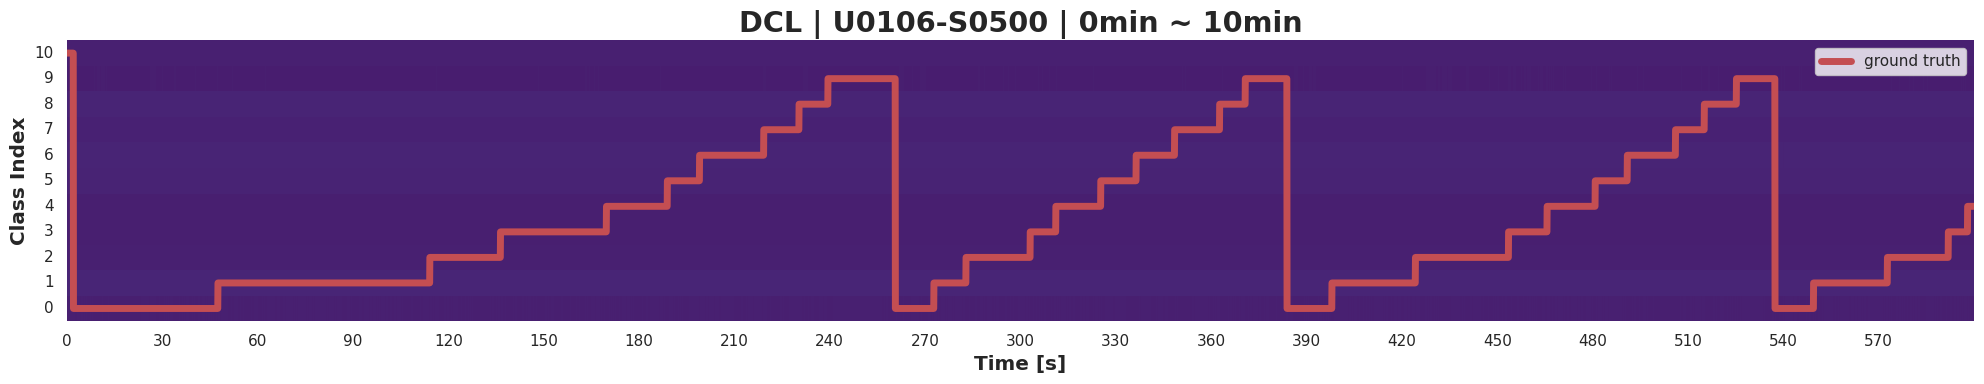

In [22]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

How to see the heatmap:

- Red line: ground truth
- Background: Prediction probabilities (high probabilities are shown in yellow. All classes have a low probability of being correct because they are random before training).
- Horizontal axis: time
- Vertical axis: Index of the action class (1 = Picking[ID100], 2=Relocate Label[ID=200], ...)

Please remember these results before training and compare them with the results after training.

#### 6-4-2: Training

In [23]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

INFO:__main__:Start training for 50 epochs.
2024-02-04 06:44:11 | INFO | __main__ | Start training for 50 epochs.
INFO:openpack_torch.data.datamodule:dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
2024-02-04 06:44:13 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False, random_crop=True)
INFO:openpack_torch.data.datamodule:dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5bc7767b50>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5bc77f8a90>}
2024-02-04 06:44:13 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5bc7767b50>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5bc77f8a90>}
INFO:openpack_torch.data.datamodule:dataset[test]: None
2024-02-04 06:44:13 | INFO | openpack_torch.data.datamodule | dataset[test]: None
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
2024-02-04 06:45:33 | INFO | pytorch_lightning.utilities.rank_zero | `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:__main__:Finish training!
2024-02-04 06:45:33 | INFO | __main__ | Finish training!


#### 6-4-5: Plot Training Curve

To verify that the model is training well, plot the change in loss per epoch.
Observe that the loss gradually decreases as the epoch progresses.

In [24]:
pl_logdir = Path(cfg.path.logdir.rootdir, "lightning_logs/")
latest_logdir = list(sorted(pl_logdir.iterdir()))[-1]

df = pd.read_csv(Path(latest_logdir, "metrics.csv"))
df["phase"] = df["train/loss"].apply(lambda x: "val" if np.isnan(x) else "train")
df = df.set_index(["epoch", "phase"])

In [25]:
df.head()

val/loss/dataloader_idx_0  step  val/loss/dataloader_idx_1  val/acc/dataloader_idx_1  val/acc/dataloader_idx_0  train/acc  train/loss
epoch phase                                                                                                                                       
0     val                     2.025792    66                   1.989245                  0.270179                  0.252922        NaN         NaN
      train                        NaN    66                        NaN                       NaN                       NaN   0.313306    1.942754
1     val                     1.981256   133                   2.040891                  0.272650                  0.284048        NaN         NaN
      train                        NaN   133                        NaN                       NaN                       NaN   0.365992    1.723539
2     val                     2.016826   200                   2.006739                  0.287880                  0.277061        NaN         NaN

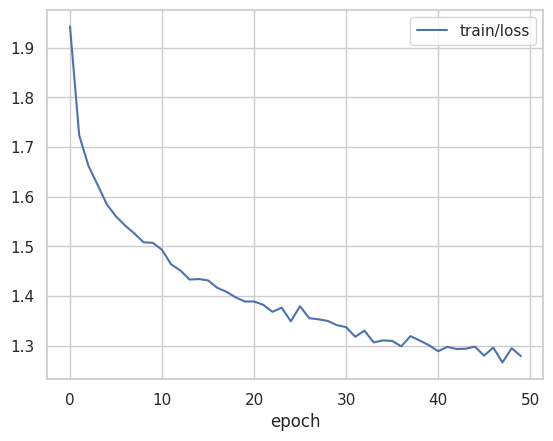

In [26]:
df.xs("train", level="phase")[["train/loss"]].plot()
plt.show()

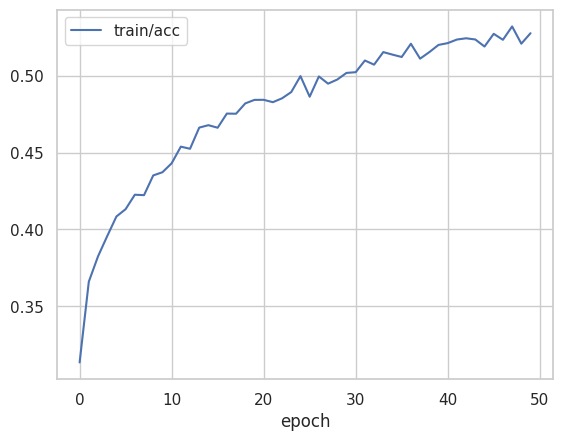

In [27]:
df.xs("train", level="phase")[["train/acc"]].plot()
plt.show()

### 6-5: Evaluation

In [28]:
# Evaluate on test set
plmodel.clear_test_outputs()
datamodule.setup("test")

outputs, df_summary = test_helper(cfg, "test", datamodule, plmodel, trainer)

INFO:openpack_torch.data.datamodule:dataset[train]: None
2024-02-04 06:45:48 | INFO | openpack_torch.data.datamodule | dataset[train]: None
INFO:openpack_torch.data.datamodule:dataset[val]: None
2024-02-04 06:45:48 | INFO | openpack_torch.data.datamodule | dataset[val]: None
INFO:openpack_torch.data.datamodule:dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92aa3e80>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92a8c0d0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b9312af20>}
2024-02-04 06:45:48 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92aa3e80>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b92a8c0d0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7d5b9312af20>}
INFO:openpack_torch.data.datamodule:dataset[submission]: None
2024-02-04 06:45:48 | INFO |

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
2024-02-04 06:45:49 | INFO | openpack_torch.utils.test_helper | save t[shape=(50, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
2024-02-04 06:45:49 | INFO | openpack_torch.utils.test_helper | save y[shape=(50, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0100/y.npy
INFO:openpack_to

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
2024-02-04 06:45:50 | INFO | openpack_torch.utils.test_helper | save t[shape=(85, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
2024-02-04 06:45:50 | INFO | openpack_torch.utils.test_helper | save y[shape=(85, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0300/y.npy
INFO:openpack_to

Testing: |          | 0/? [00:00<?, ?it/s]

INFO:openpack_torch.utils.test_helper:save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
2024-02-04 06:45:50 | INFO | openpack_torch.utils.test_helper | save t[shape=(103, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/t.npy
INFO:openpack_torch.utils.test_helper:save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
2024-02-04 06:45:50 | INFO | openpack_torch.utils.test_helper | save y[shape=(103, 11, 1800)] to /content/data/log/benchmark1/I01-EXP1-V1-nb/openpack-operations-1hz-annotation/pilot-challenge-split/atr02-iot/DCL/adam-exp/LR0.001/RUN0/pred/last/U0106-S0500/y.npy
INFO:openpac

#### Metrics:

- Precision
- Recall
- F1-measure (metrics used in OpenPack Challenge 2022)


In [29]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key,scenario
36,avg/macro,-1,0.351903,0.281612,0.255968,None,all,S1
37,avg/weighted,-1,0.361833,0.309043,0.272883,None,all,S1
38,Picking,100,0.352564,0.199275,0.254630,552,all,S1
39,Relocate Item Label,200,0.291224,0.554255,0.381825,940,all,S1
40,Assemble Box,300,0.404237,0.442085,0.422314,1036,all,S1
41,Insert Items,400,0.288156,0.482618,0.360856,489,all,S1
42,Close Box,500,0.241309,0.354354,0.287105,666,all,S1
43,Attach Box Label,600,0.259740,0.168539,0.204429,356,all,S1
44,Scan Label,700,0.666667,0.002941,0.005857,680,all,S1
45,Attach Shipping Label,800,0.453333,0.147186,0.222222,462,all,S1


#### Visualization

In [30]:
# Segment key to visualize
key = "U0106-S0500"

# Get predictions
unixtimes = outputs[key]["unixtime"]
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(103, 1800), t_idx=(103, 1800), y=(103, 11, 1800), y_softmax=(103, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


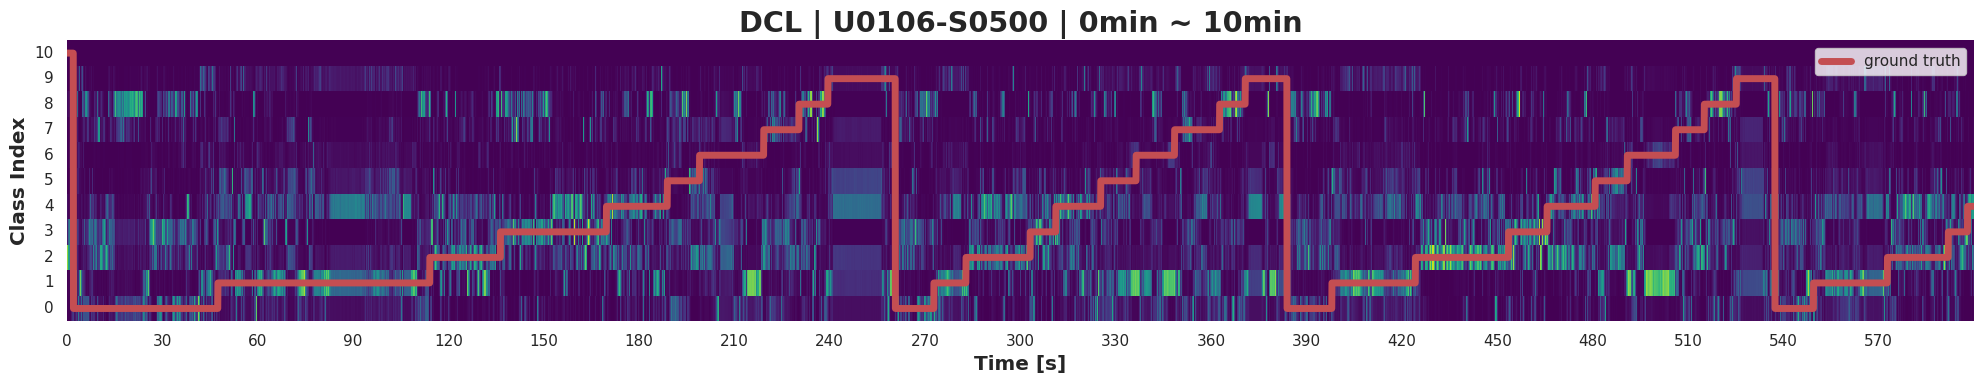

In [31]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

How does the output compare to the pre-study diagram?
You can see that the area around the red correct answer label has turned yellow. With some modeling, the score can be increased to nearly 90%. Try different models and parameters.